## Photo Tagger with PyTorch in SageMaker Studio

Let's use the sample dataset "house-rooms-image-dataset" from Kaggle:
https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset

we will download it using the Kaggle API... (make sure you download your kaggle.json file first).

In [5]:
!pip install kaggle --quiet

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d robinreni/house-rooms-image-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|███████████████████████████████████████▊| 116M/116M [00:04<00:00, 37.4MB/s]
100%|████████████████████████████████████████| 116M/116M [00:05<00:00, 22.9MB/s]


In [ ]:
!unzip -q house-rooms-image-dataset.zip

In [18]:
!pip install split-folders --quiet
!pip install livelossplot --quiet

In [19]:
import splitfolders
splitfolders.ratio('House_Room_Dataset', output="Split_Dataset", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 5250 files [01:55, 45.61 files/s]


In [2]:
# LIBRARIES
#*********************
#!cp drive/MyDrive/10_PROJECTS/photo_tagger/helpers.py .
#!cp drive/MyDrive/10_PROJECTS/photo_tagger/mean_and_std.pt .

import torchvision.datasets
import torchvision.transforms as T
import torchvision.models
import torch.optim
import torch.nn.functional as F
from torch import nn
#from helpers import *
import glob
import matplotlib.pyplot as plt

In [3]:
# SETTINGS
#**************************************************
batch_size = 32        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
n_epochs = 5        # number of epochs for training
#dropout = 0.4          # dropout for our model
learning_rate = 0.05  # Learning rate for SGD (or Adam)
momentum = 0.5 
weight_decay = 0.01     # regularization. Increase this to combat overfitting

In [4]:
# DATA LOADERS
#*********************
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

# Load the Data
# Set train and valid directory paths
train_directory = 'Split_Dataset/train'
valid_directory = 'Split_Dataset/val'
test_directory = 'Split_Dataset/test'
# Batch size
bs = 32
# Number of classes
num_classes = 5

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=transform),
    'valid': datasets.ImageFolder(root=valid_directory, transform=transform),
    'test': datasets.ImageFolder(root=test_directory, transform=transform)
    #'train': datasets.ImageFolder(root=train_directory),
    #'valid': datasets.ImageFolder(root=valid_directory),
    #'test': datasets.ImageFolder(root=test_directory)
}
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])
# Create iterators for the Data loaded using DataLoader module
train = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test = DataLoader(data['test'], batch_size=bs, shuffle=True)

#data_loaders = get_data_loaders(batch_size=batch_size,valid_size=valid_size)
data_loaders={
    "train": train,
    "valid": valid,
    "test": test
}
n_classes = len(data_loaders["train"].dataset.classes)

# Print the train, validation and test set data sizes
print(train_data_size, valid_data_size, test_data_size, n_classes)

4198 522 530 5


In [5]:
# TRANSFER MODEL: FREEZE BACKBONE AND THAW THE HEAD
#**************************************************

model = torchvision.models.resnet50(pretrained=True)

n_inputs = model.fc.in_features

# Feel free to experiment with more complicated heads
model.fc = nn.Linear(n_inputs, n_classes)

frozen_parameters = []
for p in model.parameters():
    # Freeze only parameters that are not already frozen
    # (if any)
    if p.requires_grad:
        p.requires_grad = False
        frozen_parameters.append(p)

print(f"Froze {len(frozen_parameters)} groups of parameters")

# Now let's thaw the parameters of the head we have
# added
for p in model.fc.parameters():
    p.requires_grad = True

Froze 161 groups of parameters


In [6]:
# TRAIN, VALIDATION
#*********************************
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay)

#model.load_state_dict(torch.load('/root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth'))

In [7]:
#optimize(
#    data_loaders,
#    model,
#    optimizer,
#    loss,
#    n_epochs=n_epochs,
#    save_path="./checkpoints/model_estimated.pt",
#    interactive_tracking=False
#)

In [8]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(n_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, n_epochs))
        # Set to training mode
        model.train()
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        for i, (inputs, labels) in enumerate(data_loaders["train"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            # Compute loss
            losst = loss(outputs, labels)
            # Backpropagate the gradients
            losst.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss += losst.item() * inputs.size(0)
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, losst.item(), acc.item()))

Epoch: 1/5
[2023-02-27 11:28:51.218 1-8-1-cpu-py36-ml-g4dn-xlarge-5b0c5292be3b9805b73bbd06ca03:34 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-27 11:28:51.391 1-8-1-cpu-py36-ml-g4dn-xlarge-5b0c5292be3b9805b73bbd06ca03:34 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Batch number: 000, Training: Loss: 1.6514, Accuracy: 0.1562
Batch number: 001, Training: Loss: 3.2754, Accuracy: 0.2188
Batch number: 002, Training: Loss: 4.1699, Accuracy: 0.2812
Batch number: 003, Training: Loss: 6.9756, Accuracy: 0.2188
Batch number: 004, Training: Loss: 7.1840, Accuracy: 0.1250
Batch number: 005, Training: Loss: 10.1308, Accuracy: 0.2188
Batch number: 006, Training: Loss: 6.8404, Accuracy: 0.2188
Batch number: 007, Training: Loss: 8.1000, Accuracy: 0.1562
Batch number: 008, Training: Loss: 7.4743, Accuracy: 0.2500
Batch number: 009, Training: Loss: 12.2053, Accuracy: 0.2812
Batch number: 010, Training: Loss:

In [9]:
output_model = './model.pth'

# save
def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(model, optimizer)

In [17]:
# TEST
#****************
model = torchvision.models.resnet50(pretrained=True)

n_inputs = model.fc.in_features

# Feel free to experiment with more complicated heads
model.fc = nn.Linear(n_inputs, n_classes)

frozen_parameters = []
for p in model.parameters():
    # Freeze only parameters that are not already frozen
    # (if any)
    if p.requires_grad:
        p.requires_grad = False
        frozen_parameters.append(p)

print(f"Froze {len(frozen_parameters)} groups of parameters")

# Now let's thaw the parameters of the head we have
# added
for p in model.fc.parameters():
    p.requires_grad = True

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load(output_model)["model_state_dict"])

# Run test
#_ = one_epoch_test(data_loaders['test'], model, loss)

Froze 161 groups of parameters


<All keys matched successfully>

In [39]:
# EXPORT USING TORCHSCRIPT
#*********************************
class Predictor(nn.Module):

    def __init__(self, model, class_names, mean, std):
        super().__init__()

        self.model = model.eval()
        self.class_names = class_names

        # We use nn.Sequential and not nn.Compose because the former
        # is compatible with torch.script, while the latter isn't
        self.transforms = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize(mean.tolist(), std.tolist())
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            # 1. apply transforms
            x  = self.transforms(x)
            # 2. get the logits
            x  = self.model(x) 
            # 3. apply softmax
            x  = F.softmax(x, dim=1)

            return x

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model to the CPU
# (we don't need GPU for inference)
model = model.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model.load_state_dict(
    torch.load("./model.pth", map_location="cpu")["model_state_dict"]
)

# Let's wrap our model using the predictor class
#mean, std = compute_mean_and_std()
#predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
#scripted_predictor = torch.jit.script(predictor)
#scripted_predictor.save("./model_exported.pt")

<All keys matched successfully>

In [38]:
# TEST EXPORTED MODEL
#*************************
#from tqdm import tqdm

#def predictor_test(test_dataloader, model_reloaded):
#    """
#    Test the predictor. Since the predictor does not operate on the same tensors
#    as the non-wrapped model, we need a specific test function (can't use one_epoch_test)
#    """

    #folder = get_data_location()
    #test_data = datasets.ImageFolder(os.path.join(folder, "test"), transform=T.ToTensor())
#    test_data = datasets.ImageFolder(root=test_directory, transform=T.ToTensor())

#    pred = []
#    truth = []
#    for x in tqdm(test_data, total=len(test_dataloader.dataset), leave=True, ncols=80):
#        softmax = model_reloaded(x[0].unsqueeze(dim=0))

#        idx = softmax.squeeze().argmax()

#        pred.append(int(x[1]))
#        truth.append(int(idx))

#    pred = np.array(pred)
#    truth = np.array(truth)

#    print(f"Accuracy: {(pred==truth).sum() / pred.shape[0]}")

#    return truth, pred

#model_reloaded = torch.load("./model.pth")

#pred, truth = predictor_test(data_loaders['test'], model_reloaded)

In [37]:
#classes = data_loaders["train"].dataset.classes

#plot_confusion_matrix(pred, truth, classes)

<AxesSubplot:>

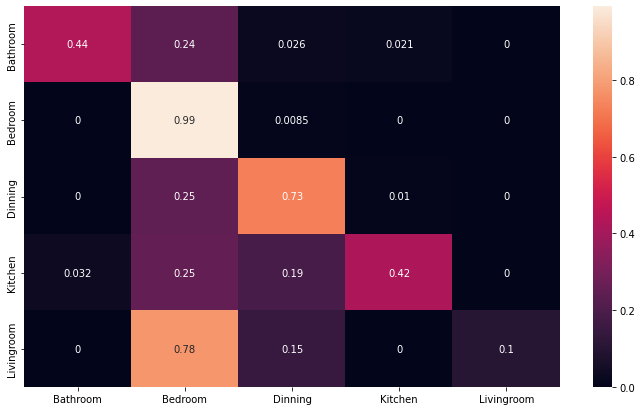

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = data_loaders["train"].dataset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')